In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose, BatchNormalization, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import argparse
import os
from dataparse import parse

Set rcParams for nice plotting

In [2]:
rcParams['figure.figsize'] = (10,6)
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = '--'
rcParams['xtick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['ytick.right'] = True

### Define Params and Paths

In [3]:
data_labels = ['Radius','Angle','Z','t0','Energy']
plotmodel = True #If True the VAE model tree is plotted
savefigs = False #IF True, the scatter plots are saved

Define Plotting and Helping functions

In [5]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def get_data(fname,key,flatten=True, mode = '1d'):
    # Was trying to speed up the parse function, but
    # I'm not sure this function is equivalent at the moment
    df = pd.read_hdf(fname,key=key,mode='r')
    tms = np.stack(df.tm.values)[...,np.newaxis]
    if flatten:
        tms = tms.reshape((tms.shape[0], tms.shape[1]*tms.shape[2], tms.shape[-1]))
    params = np.stack(df.epos)
    epos = params[[1,2,3,4,0]]
    S = params[:,-1]
    if mode == '2d':
        S = np.repeat(S[:,np.newaxis], 11, axis=1)
    return tms, epos, S

In [6]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist",
                 labels=None,
                 savefigs=False):
    
    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    if labels is None:
        labels = np.arange(y_test.shape[-1]-1)
        
    for ii in range(y_test.shape[-1]-1):
        name_fig=f'{filename}_{labels[ii]}.png'
        fig, ax = plt.subplots()
        scat = ax.scatter(z_mean[:, 0], z_mean[:, 1], s=5, alpha=0.7, c=y_test[:,ii])
        fig.colorbar(scat, label=f'True Value for Parameter {labels[ii]}')
        ax.set_xlabel("z[0]")
        ax.set_ylabel("z[1]")
        ax.set_title(f'Predictions for Parameter {labels[ii]}')
        if savefigs:
            fig.savefig(name_fig)
        fig.tight_layout()

In [7]:
def drawOutput_fromLatent(decoder, savefigs=False):
    z=[0,3]
    input_z = np.array([z])
    data = decoder.predict(input_z,batch_size=1)
    fig = plt.figure()
    plt.plot(data[0,:,:,0].transpose(),".")
    if savefigs:
        fig.savefig("./traces/trace.png")
    fig.tight_layout()
    

Load and clean data

In [8]:
# Load MC dataset
dataset = '/gpfs/slac/staas/fs1/g/supercdms/dl/mc/180720.h5'
mode = '2d'
# Split training and test data
(x_train, y_train, s_train) =  parse(dataset,key='train',flatten=False,mode=mode)
(x_test, y_test, s_test) =  parse(dataset,key='dev',flatten=False,mode=mode)

# (x_train, y_train, s_train) =  get_data(dataset,key='train',flatten=False,mode=mode)
# (x_test, y_test, s_test) =  get_data(dataset,key='dev',flatten=False,mode=mode)

n_channels = 10

#inverting negative and normalizing data
max = np.amax(x_train[:,:n_channels,:875],axis=2)
max = np.amax(max, axis=1)
for i in range(x_train.shape[0]):
    for l in range(n_channels):
        if (max[i] <= 0): 
            x_train[i,l,:875] *= -1
            max[i] = np.amax(x_train[i,l,:875])
        x_train[i,l,:875] = x_train[i,l,:875]/max[i]

x_train = x_train[:,:n_channels,:875]
x_test  = x_test[:,:n_channels,:875]

x_train = x_train.astype('float32')
x_test  = x_test.astype('float32') 

image_size_x = x_train.shape[1]
image_size_y = x_train.shape[2]

x_train = np.reshape(x_train, [-1, image_size_x, image_size_y, 1])
x_test = np.reshape(x_test, [-1, image_size_x, image_size_y, 1])



Define parameters of VAE

In [9]:
# network parameters
input_shape = (image_size_x, image_size_y, 1)
batch_size = 128
kernel_size = (3,5)
filters = 8
latent_dim = 2
epochs = 5
stride_deco = [(1,5),(1,5),(1,5)]
stride_enco = [(1,5),(1,5),(1,5)]

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(3):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=stride_enco[i],
               activation='relu',
               padding='same')(x)
    #x = Batchnormalization(x)


# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


Instructions for updating:
Colocations handled automatically by placer.


Fit model

In [10]:


# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
if plot_model:
    plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(3):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=stride_deco[i],
                        padding='same')(x)
    filters //= 2

   
    

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)
 
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# if __name__ == '__main__':
parser = argparse.ArgumentParser()
help_ = "Load h5 model trained weights"
parser.add_argument("-w", "--weights", help=help_)
help_ = "Use mse loss instead of binary cross entropy (default)"
parser.add_argument("-m", "--mse", help=help_, action='store_true')
args = parser.parse_args(args=[])
print(args)
models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss
if args.mse:
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
else:
    reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                              K.flatten(outputs))

reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))

reconstruction_loss *= image_size_x * image_size_y
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()
if plot_model:
    plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

if args.weights:
    print('using known weights')
    vae.load_weights(args.weights)
else:
    # train the autoencoder
    print('training model:')
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    vae.save_weights('vae_cnn.h5')



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 10, 875, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 175, 16)  256         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 10, 35, 32)   7712        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 10, 7, 64)    30784       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

Make plots

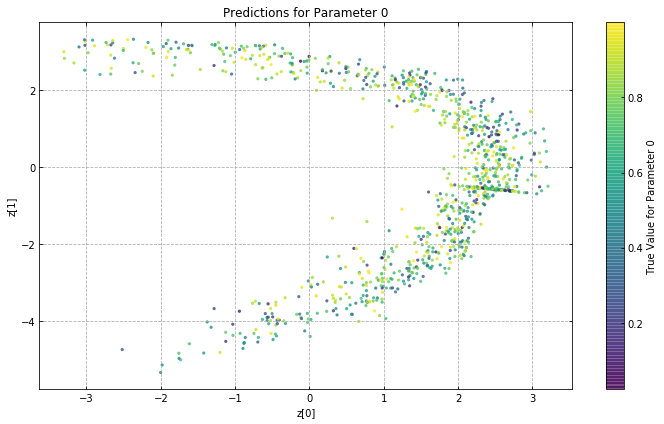

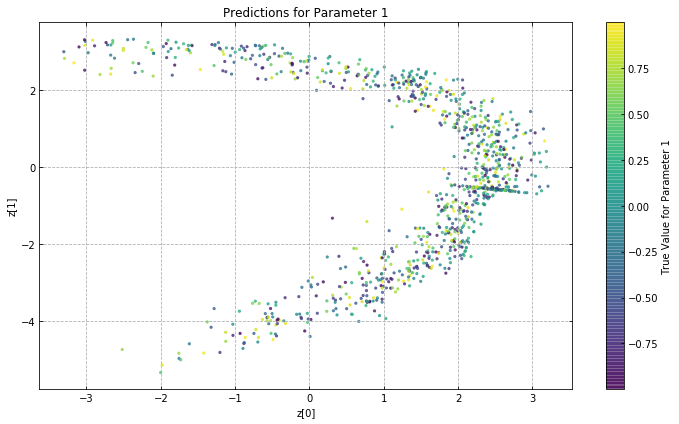

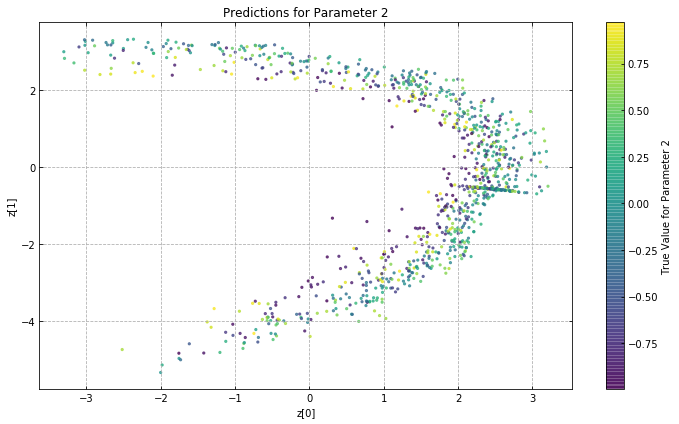

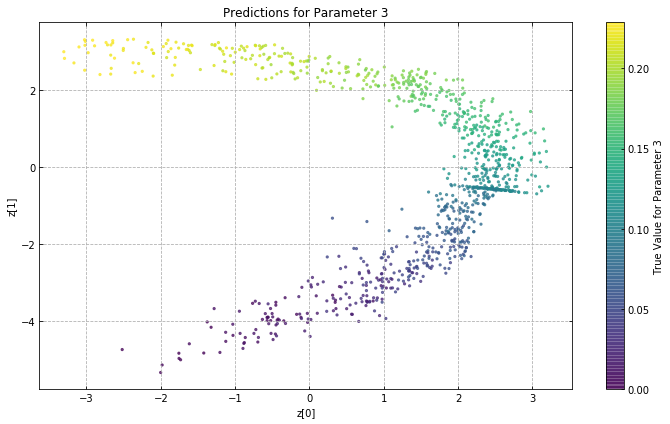

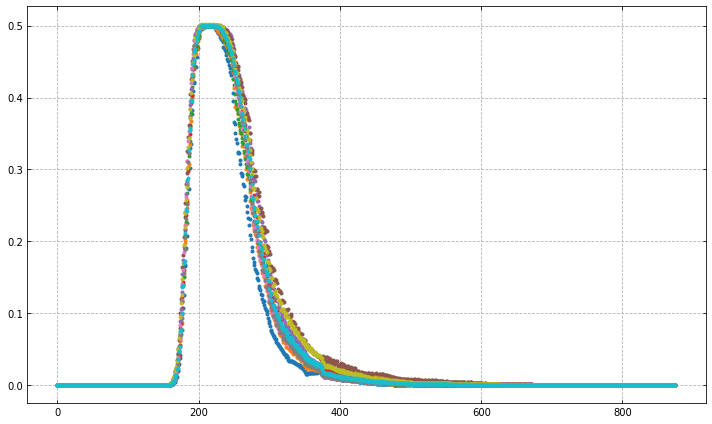

In [11]:
plot_results(models, data, batch_size=batch_size, model_name="vae_cnn", labels=None, savefigs=savefigs)

drawOutput_fromLatent(decoder,savefigs=savefigs)